**Import modułów**

In [2]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib. pyplot as plt

### Wstępna analiza
Do odpalenia poniższego kodu wymagane jest wykonanie importu modułów, oraz klas: Iris_analysis oraz Mushrooms_analysis

In [22]:
class Iris_preliminary_analysis:
    iris = load_iris()
    target_column = "species"
    iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
    iris_df[target_column] = iris.target  # Dodajemy kolumnę z etykietami klas

    def plot_histograms(self):
        self.iris = load_iris()
        iris_df = pd.DataFrame(self.iris.data, columns=self.iris.feature_names)
        iris_df[self.target_column] = self.iris.target  # Dodajemy kolumnę z etykietami klas

        iris_df.hist(figsize=(10, 8), bins=25)
        plt.suptitle("Histogramy cech w zbiorze Iris")
        plt.show()

    def plot_pairplot(self):
        iris_df = pd.DataFrame(self.iris.data, columns=self.iris.feature_names)
        iris_df['species'] = self.iris.target  # Dodajemy kolumnę z etykietami klas

        species_mapping = {0: "Setosa", 1: "Versicolor", 2: "Virginica"}
        iris_df[self.target_column] = iris_df[self.target_column].map(species_mapping)

        sns.pairplot(iris_df, hue=self.target_column, markers=["o", "s", "D"], )
        plt.suptitle("Pairplot zbioru Iris", y=1.02)

        plt.show()
    
    def plot_violin(self):
        iris_df = pd.DataFrame(self.iris.data, columns=self.iris.feature_names)
        iris_df['species'] = self.iris.target  # Dodajemy kolumnę z etykietami klas
        plt.figure(figsize=(12,6))
        for i, col in enumerate(iris_df.columns[:-1]):  # Wszystkie cechy numeryczne
            plt.subplot(2,2,i+1)
            sns.violinplot(x=iris_df[self.target_column], y=iris_df[col])
            plt.title(f"Violin plot dla {col}")
        
        species_mapping = {0: "Setosa", 1: "Versicolor", 2: "Virginica"}
        iris_df[self.target_column] = iris_df[self.target_column].map(species_mapping)

        plt.tight_layout()
        plt.show()

    def plot_boxplot(self):
        plt.figure(figsize=(10,6))
        sns.boxplot(data=self.iris_df)
        plt.title("Boxplot cech w zbiorze Iris")
        plt.show()

iris_pre_analysis = Iris_preliminary_analysis()

In [8]:
class Mushrooms_preliminary_analysis:
    file_path = "./mushroom-classification/mushrooms.csv"
    mushrooms = pd.read_csv(file_path)
    target_column = 'class'        

    def features_plots(self):
        for col in self.mushrooms.columns:
            plt.figure(figsize=(6, 4))
            sns.countplot(x=self.mushrooms[col])
            plt.title(f"Rozkład wartości cechy: {col}")
            plt.xticks(rotation=45)
            plt.show()
    
    def poisonous_edible_plots(self):
        for col in self.mushrooms.columns[1:]:  # Pomijamy "class"
            plt.figure(figsize=(6, 4))
            sns.countplot(x=self.mushrooms[col], hue=self.mushrooms["class"])
            plt.title(f"{col} w podziale na klasy (jadalne vs trujące)")
            plt.xticks(rotation=45)
            plt.show()
        
mushrooms_pre_analysis = Mushrooms_preliminary_analysis()

Analiza Mushrooms

In [ ]:
# wykresy poszczególnych cech (w analizie wklejałem tylko te, które przedstawiają więcej niż 2 wartości. Dla binarnych wykresów tylko wstawiłem proporcję)
mushrooms_pre_analysis.features_plots()

In [ ]:
# wykresy poszczególnych cech w zależności od bycia trującym (p - trujące, e - jadalne)
mushrooms_pre_analysis.poisonous_edible_plots()

Analiza Iris

In [ ]:
# Rysowanie histogramu
iris_pre_analysis.plot_histograms()

In [ ]:
# Rysowanie pairplotu
iris_pre_analysis.plot_pairplot()

In [ ]:
# Rysowanie wykresu wiolinowego
iris_pre_analysis.plot_violin()

In [ ]:
iris_pre_analysis.plot_boxplot()

### Klasa naiwnego klasyfikatora Bayesowskiego dla cech kategorycznych

In [356]:
class MultinomialNaiveBayesClassifier:
    def __init__(self):
        self.class_log_probability = {}  # Logarytmiczne prawdopodobieństwa a priori dla każdej klasy
        self.conditional_log_probability = {}  # Logarytmiczne prawdopodobieństwa warunkowe cech względem klas
        self.epsilon = None  # Bardzo mała liczba używana zamiast zera, mala po uzyciu potegi, aby uniknąć problemów z log(0)
        self.target_column = None  # Nazwa kolumny, względem której dokonujemy predykcji

    def fit(self, X_train, column_name, epsilon):
        """
        Trenuje model na podstawie dostarczonego zbioru danych.

        Parametry:
        X_train - DataFrame zawierający dane treningowe
        column_name - nazwa kolumny z etykietami (klasami)
        epsilon - bardzo mała liczba używana zamiast zera, aby uniknąć problemów z mnożeniem zerowych prawdopodobieństw.
        
        Nie zwraca nic.
        """
        y = X_train[column_name]
        self.target_column = column_name
        self.epsilon = epsilon

        # Obliczanie logarytmicznych prawdopodobieństw a priori dla każdej klasy
        for class_label in y.unique():
            self.class_log_probability[class_label] = np.log(len(y[y == class_label]) / len(y))

        # Obliczanie logarytmicznych prawdopodobieństw warunkowych dla każdej cechy względem każdej klasy
        for column in X_train.columns:
            if column == column_name:
                continue

            self.conditional_log_probability[column] = {}
            for value in X_train[column].unique():
                self.conditional_log_probability[column][value] = {}
                
                if value == "?":
                    continue
                # Uwzglednienie braku wartosci
                
                for class_label in y.unique():
                    feature_count = len(y[y == class_label])
                    conditional_count = len(X_train[(y == class_label) & (X_train[column] == value)])

                    if feature_count > 0 and conditional_count > 0:
                        self.conditional_log_probability[column][value][class_label] = np.log(conditional_count / feature_count)
                    else:
                        self.conditional_log_probability[column][value][class_label] = epsilon  # Bardzo mała liczba zamiast log(0)

    def predict_with_option(self, row_to_predict, return_single):
        """
        Przewiduje klasy dla dostarczonego wiersza z opcją zwracania prawdopodobieństw.

        Parametry:
        row_to_predict - Series zawierający dane wejściowe do predykcji
        return_single - jeśli True, zwraca pojedynczą przewidywaną klasę, jeśli False zwraca prawdopodobieństwa

        Zwraca:
        Jeśli return_single=True -> przewidywana klasa (str)
        Jeśli return_single=False -> lista prawdopodobieństw dla każdej klasy
        """
        log_probability_per_class = {}

        # Obliczanie logarytmicznego prawdopodobieństwa dla każdej klasy
        for class_label in self.class_log_probability:
            log_probability = self.class_log_probability[class_label]

            for column, value in row_to_predict.items():
                if column == self.target_column:
                    continue

                if value in self.conditional_log_probability[column]:
                    log_conditional_probability = self.conditional_log_probability[column][value].get(class_label, self.epsilon)
                    log_probability += log_conditional_probability
                else:
                    log_probability += self.epsilon  # Brak warunku oznacza bardzo małe prawdopodobieństwo

            log_probability_per_class[class_label] = log_probability

        # Zwracanie wyniku w zależności od opcji return_single
        if return_single:
            return max(log_probability_per_class, key=log_probability_per_class.get)
        else:
            return {class_label: np.exp(log_prob) for class_label, log_prob in log_probability_per_class.items()}

    def predict(self, row_to_predict):
        """
        Przewiduje klasę dla pojedynczego wiersza danych.

        Parametry:
        row_to_predict - Series zawierający dane wejściowe do predykcji

        Zwraca:
        Przewidywana klasa (str)
        """
        return self.predict_with_option(row_to_predict, True)

    def predict_proba(self, row_to_predict):
        """
        Zwraca prawdopodobieństwa dla każdej klasy dla pojedynczego wiersza danych.

        Parametry:
        row_to_predict - Series zawierający dane wejściowe do predykcji

        Zwraca:
        Słownik prawdopodobieństw dla każdej klasy
        """
        return self.predict_with_option(row_to_predict, False)

### Klasa naiwnego klasyfikatora Bayesowskiego dla cech ilościowych

In [350]:
class GaussianNaiveBayesClassifier:
    def __init__(self):
        self.class_log_probability = {}  # Logarytmiczne prawdopodobieństwa a priori dla każdej klasy
        self.gaussian_parameters = {}  # Średnie i odchylenia standardowe cech względem klas
        self.target_column = None  # Nazwa kolumny z etykietami klas
        self.epsilon = None  # Bardzo mała liczba, aby uniknąć log(0)

    def fit(self, X_train, column_name, epsilon):
        """
        Trenuje model Gaussowskiego Naive Bayes na podstawie danych treningowych.

        Parametry:
        X_train - DataFrame zawierający dane treningowe
        column_name - nazwa kolumny z etykietami (klasami)
        epsilon - bardzo mała liczba używana zamiast zera, aby uniknąć problemów z logarytmowaniem zerowych prawdopodobieństw

        Nie zwraca nic.
        """
        y = X_train[column_name]
        self.target_column = column_name
        self.epsilon = epsilon

        # Obliczanie logarytmicznych prawdopodobieństw a priori dla każdej klasy
        for class_label in y.unique():
            self.class_log_probability[class_label] = np.log(len(y[y == class_label]) / len(y))

        # Obliczanie średnich i odchyleń standardowych dla każdej cechy względem każdej klasy
        for class_label in y.unique():
            class_data = X_train[X_train[column_name] == class_label]
            feature_mean = class_data.mean()
            feature_std = class_data.std()
            self.gaussian_parameters[class_label] = {}

            for column in X_train.columns:
                if column == column_name:
                    continue
                self.gaussian_parameters[class_label][column] = (feature_mean[column], feature_std[column])

    @staticmethod
    def log_gaussian_density(x, mean, std):
        """
        Oblicza logarytm funkcji Gaussa (gęstości rozkładu normalnego) dla danej wartości x.

        Parametry:
        x    - wartość, dla której obliczamy funkcję gęstości
        mean - średnia rozkładu
        std  - odchylenie standardowe rozkładu

        Zwraca:
        Logarytm wartości funkcji Gaussa dla zadanych parametrów.
        """
        eps = 1e-9  # Mała wartość, aby uniknąć dzielenia przez zero
        coeff = -0.5 * np.log(2.0 * np.pi * (std**2 + eps))
        exponent = -((x - mean)**2) / (2.0 * (std**2 + eps))
        return coeff + exponent

    def predict_with_option(self, row_to_predict, return_single):
        """
        Przewiduje klasy dla dostarczonego wiersza z opcją zwracania prawdopodobieństw.

        Parametry:
        row_to_predict - Series zawierający dane wejściowe do predykcji
        return_single - jeśli True, zwraca pojedynczą przewidywaną klasę, jeśli False zwraca prawdopodobieństwa

        Zwraca:
        Jeśli return_single=True -> przewidywana klasa (str)
        Jeśli return_single=False -> lista prawdopodobieństw dla każdej klasy
        """
        log_probability_per_class = {}

        # Obliczanie logarytmicznego prawdopodobieństwa dla każdej klasy
        for class_label in self.class_log_probability:
            log_probability = self.class_log_probability[class_label]

            for column, value in row_to_predict.items():
                if column == self.target_column:
                    continue

                if column in self.gaussian_parameters[class_label]:
                    mean, std = self.gaussian_parameters[class_label][column]
                    log_probability += self.log_gaussian_density(value, mean, std)
                else:
                    log_probability += self.epsilon  # Brak warunku oznacza bardzo małe prawdopodobieństwo

            log_probability_per_class[class_label] = log_probability

        # Zwracanie wyniku w zależności od opcji return_single
        if return_single:
            return max(log_probability_per_class, key=log_probability_per_class.get)
        else:
            return {class_label: np.exp(log_prob) for class_label, log_prob in log_probability_per_class.items()}

    def predict(self, row_to_predict):
        """
        Przewiduje klasę dla pojedynczego wiersza danych.

        Parametry:
        row_to_predict - Series zawierający dane wejściowe do predykcji

        Zwraca:
        Przewidywana klasa (str)
        """
        return self.predict_with_option(row_to_predict, True)

    def predict_proba(self, row_to_predict):
        """
        Zwraca prawdopodobieństwa dla każdej klasy dla pojedynczego wiersza danych.

        Parametry:
        row_to_predict - Series zawierający dane wejściowe do predykcji

        Zwraca:
        Słownik prawdopodobieństw dla każdej klasy
        """
        return self.predict_with_option(row_to_predict, False)

### Ocena modelu

Do wykonania poniższego kodu należy wykonać kod obu klas: MultinomialNaiveBayesClassifier oraz GaussianNaiveBayesClassifier

**Funkcje używane do oceny dokładności modelów**

In [31]:
# testuje model na zadanych parametrach, i zwraca te tablice - jedna poprawnego wyniku, a druga przewidywanego
def test_model(_model: MultinomialNaiveBayesClassifier | GaussianNaiveBayesClassifier,
                     _set: pd.DataFrame, 
                     _target_column, 
                     _test_size: float=0.2, 
                     _epsilon=1e-6, 
                     _seed: int = None
        ) -> tuple[np.array, np.array]:
    
    # Podział na zbiory treningowy i testowy
    X_train, X_test = train_test_split(_set, test_size=_test_size, random_state=_seed)

    # trenujemy model
    classifier = _model()
    classifier.fit(X_train, column_name=_target_column, epsilon=_epsilon)

    #obliczanie dokladnosci
    total_samples = len(X_test)

    predicted = []
    correct = []

    for i in range(total_samples):
        predicted.append(classifier.predict(X_test.iloc[i]))
        correct.append(X_test[_target_column].iloc[i])

    return np.array(correct), np.array(predicted)

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def print_report(correct: np.array, predict: np.array, set_name = "") -> None:
    print(f"Ocena klasyfikatora dla zbioru {set_name}:")
    print(f"Accuracy: {accuracy_score(correct, predict):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(correct, predict))

**Analiza Mushrooms**

Do wykonania poniższego kodu należy wykonać funkcje używane do oceny modelu

In [338]:
class Mushrooms_analysis:
    file_path = "./mushroom-classification/mushrooms.csv"
    mushrooms = pd.read_csv(file_path)
    target_column = 'class'
    model = MultinomialNaiveBayesClassifier

    seed : int
    test_size : float

    def __init__(self, test_size : float = 0.3, seed : int = None):
        self.seed = seed
        self.test_size = test_size

    def print_report(self):
        y_test_mush, y_pred_mush = test_model(_model=self.model, 
                                            _target_column=self.target_column, 
                                            _set=self.mushrooms, 
                                            _test_size=0.3,
                                            _seed=self.seed)

        print_report(y_test_mush, y_pred_mush, "Mushrooms")
        print("Classification Report:")
        print(classification_report(y_test_mush, y_pred_mush))
    
    def print_coorelation_matrix(self):
        mush_encoded = pd.get_dummies(self.mushrooms.drop(columns=["class"]))
        plt.figure(figsize=(12,8))
        sns.heatmap(mush_encoded.corr(), cmap="coolwarm")
        plt.title("Macierz korelacji dla Mushrooms")
        plt.show()
    
    def print_ROC_curve(self):
        from sklearn.metrics import roc_curve, auc
        
        file_path = "./mushroom-classification/mushrooms.csv"

        mushrooms = pd.read_csv(file_path)
        target_column = 'class'
        model = MultinomialNaiveBayesClassifier

        y_test_mush, y_pred_mush = test_model(_model=model, 
                                            _target_column=target_column, 
                                            _set=mushrooms, 
                                            _test_size=0.2)

        # preparing data: e -> 0, p -> 1
        y_test_mush[y_test_mush == 'e'] = 0
        y_test_mush[y_test_mush == 'p'] = 1
        y_pred_mush[y_pred_mush == 'e'] = 0
        y_pred_mush[y_pred_mush == 'p'] = 1
        y_test_mush = y_test_mush.astype('int') 
        y_pred_mush = y_pred_mush.astype('int') 

        fpr, tpr, _ = roc_curve(y_test_mush, y_pred_mush)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve dla Mushrooms")
        plt.legend(loc="lower right")
        plt.show()
    
    # funkcja wyświetla graf skuteczności modelu w zależności od rozmiaru danych treningowych
    def plot_accuracy_of_test_size(self):

        x = [i for i in range(1,100)]
        y = []
        for i in range(1,100):   
            y_test_iris, y_pred_iris = test_model(_model=self.model, 
                                      _target_column=self.target_column, 
                                      _set=self.mushrooms, 
                                      _test_size= 1-(i/100)) # size of training set
            y.append(round(accuracy_score(y_test_iris, y_pred_iris) * 100))
        
        plt.plot(x,y)
        plt.xlabel("Rozmiar zbioru treningowego [%]")
        plt.ylabel("Uzyskana skutecznośc modelu [%]")
        plt.title("Wykres skuteczności od rozmiaru zbioru treningowego")
        plt.show()

mushrooms_analysis = Mushrooms_analysis()

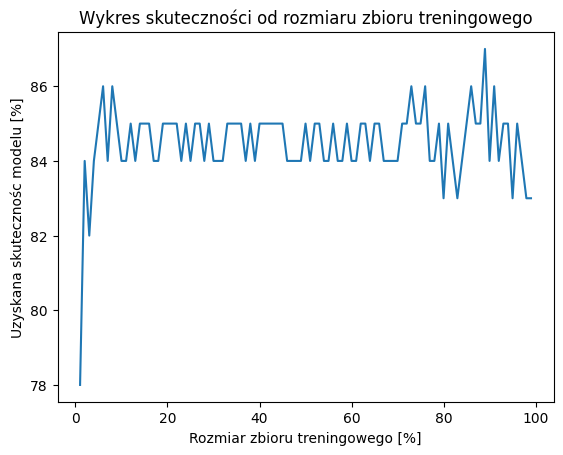

In [340]:
mushrooms_analysis.plot_accuracy_of_test_size()

In [305]:
# Generowanie raportu z oceną klasyfikatora
mushrooms_analysis.print_report()

Ocena klasyfikatora dla zbioru Mushrooms:
Accuracy: 0.8470
Confusion Matrix:
[[1130  124]
 [ 249  935]]
Classification Report:
              precision    recall  f1-score   support

           e       0.82      0.90      0.86      1254
           p       0.88      0.79      0.83      1184

    accuracy                           0.85      2438
   macro avg       0.85      0.85      0.85      2438
weighted avg       0.85      0.85      0.85      2438



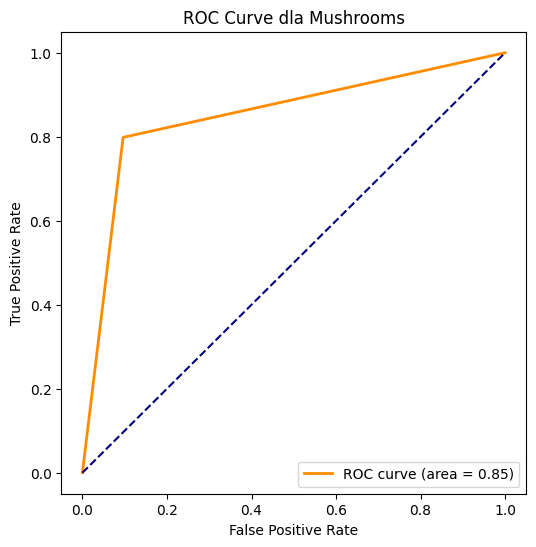

In [307]:
# Generowanie krzywej ROC (receiver operating characteristic curve)
mushrooms_analysis.print_ROC_curve()

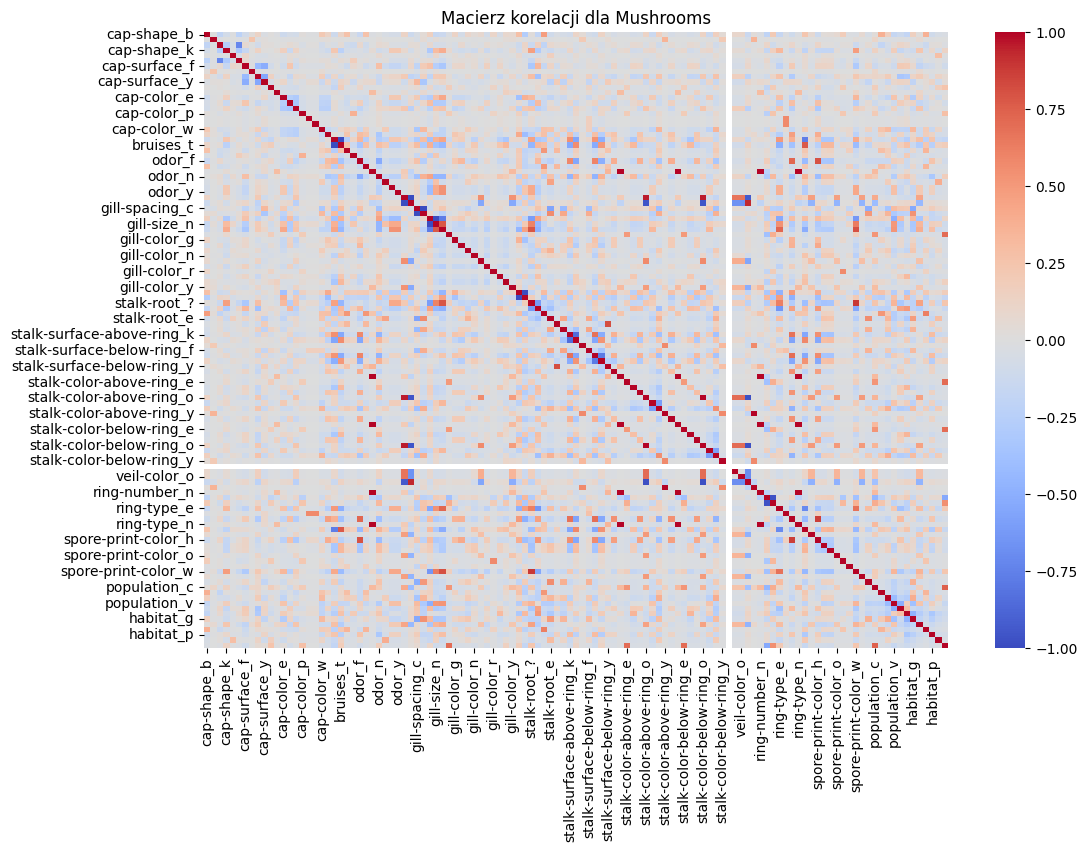

In [306]:
# Generowanie macierzy korelacji cech
mushrooms_analysis.print_coorelation_matrix()

**Analiza Iris**

In [312]:
class Iris_analysis:
    iris = load_iris()
    target_column = 'species'
    model = GaussianNaiveBayesClassifier

    def print_3d_data(self):
        from sklearn.decomposition import PCA

        fig = plt.figure(1, figsize=(8, 6))
        ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

        X_reduced = PCA(n_components=3).fit_transform(self.iris.data)
        ax.scatter(
            X_reduced[:, 0],
            X_reduced[:, 1],
            X_reduced[:, 2],
            c=self.iris.target,
            s=40,
        )

        ax.set_title("First three PCA dimensions")
        ax.set_xlabel("1st Eigenvector")
        ax.xaxis.set_ticklabels([])
        ax.set_ylabel("2nd Eigenvector")
        ax.yaxis.set_ticklabels([])
        ax.set_zlabel("3rd Eigenvector")
        ax.zaxis.set_ticklabels([])

        plt.show()

    def print_report(self):
        iris_df = pd.DataFrame(self.iris.data, columns=self.iris.feature_names)
        iris_df[self.target_column] = self.iris.target  # Dodajemy kolumnę z etykietami klas

        y_test_iris, y_pred_iris = test_model(_model=self.model, 
                                      _target_column=self.target_column, 
                                      _set=iris_df, 
                                      _test_size=0.3)


        print_report(y_test_iris, y_pred_iris)
    
    # funkcja wyświetla graf skuteczności modelu w zależności od rozmiaru danych treningowych
    def plot_accuracy_of_test_size(self):
        iris_df = pd.DataFrame(self.iris.data, columns=self.iris.feature_names)
        iris_df[self.target_column] = self.iris.target  # Dodajemy kolumnę z etykietami klas

        x = [i*10 for i in range(1,10)]
        y = []
        for i in range(1,10):   
            y_test_iris, y_pred_iris = test_model(_model=self.model, 
                                      _target_column=self.target_column, 
                                      _set=iris_df, 
                                      _test_size= 1-(i/10)) # size of training set
            y.append(round(accuracy_score(y_test_iris, y_pred_iris) * 100))
        
        plt.plot(x,y)
        plt.xlabel("Rozmiar zbioru treningowego [%]")
        plt.ylabel("Uzyskana skutecznośc modelu [%]")
        plt.title("Wykres skuteczności od rozmiaru zbioru treningowego")
        plt.show()
    
    def print_coorelation_matrix(self):
        iris_df = pd.DataFrame(self.iris.data, columns=self.iris.feature_names)
        iris_df[self.target_column] = self.iris.target  # Dodajemy kolumnę z etykietami klas
        iris_encoded = pd.get_dummies(iris_df.drop(columns=[self.target_column]))
        plt.figure(figsize=(12,8))
        sns.heatmap(iris_encoded.corr(), cmap="coolwarm")
        plt.title("Macierz korelacji dla Iris")
        plt.show()

iris_analysis = Iris_analysis()

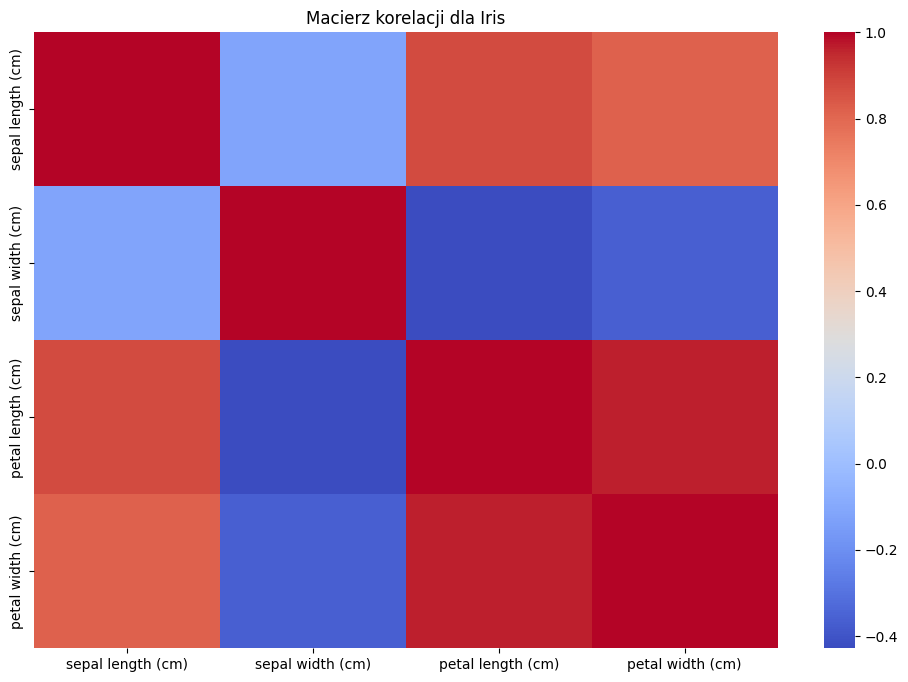

In [313]:
iris_analysis.print_coorelation_matrix()

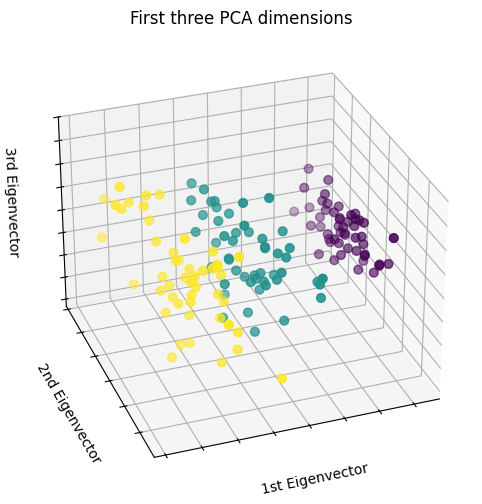

In [245]:
# ten wykres dobrze obrazuje rozdzielenie gatunków irysa
iris_analysis.print_3d_data()

In [302]:
# Generowanie raportu z oceną klasyfikatora
iris_analysis.print_report()

Ocena klasyfikatora dla zbioru :
Accuracy: 0.9556
Confusion Matrix:
[[15  0  0]
 [ 0 13  2]
 [ 0  0 15]]


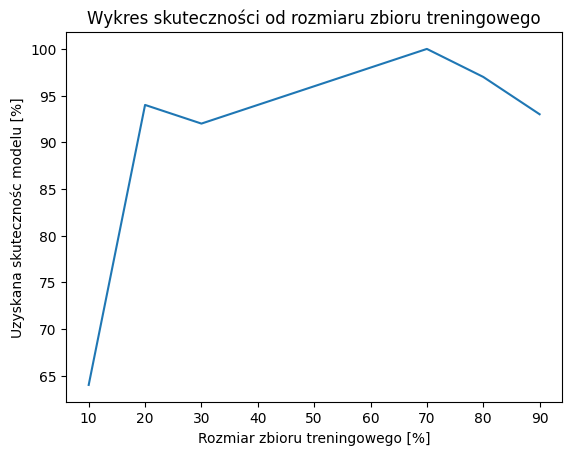

In [ ]:
# generowanie wykresu skuteczności od rozmiaru zbioru treningowego
iris_analysis.plot_accuracy_of_test_size()